In [27]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 10, 6

In [29]:
dataset = pd.read_csv("/Users/healray/Desktop/TabPy/sum_by_month.csv")
# Parse strings to datetime type
dataset['Month'] = pd.to_datetime(dataset['Month'], infer_datetime_format=True)
indexedDataset = dataset.set_index(['Month'])


In [35]:
from datetime import datetime
# print top 5 values
indexedDataset.tail(5)

,Amount
Month,
2019-09-01,936185
2019-10-01,952025
2019-11-01,942734
2019-12-01,962405
2020-01-01,1282769


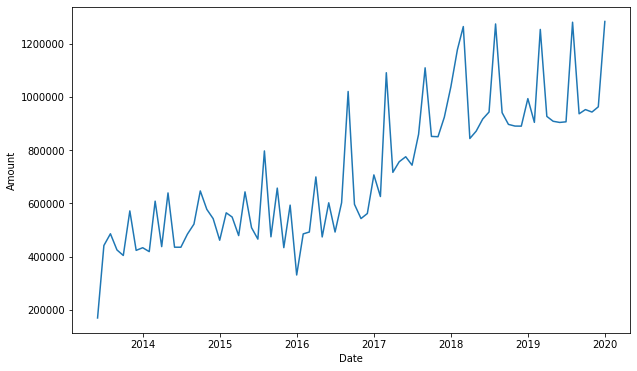

In [33]:
# plot graph

plt.xlabel("Date")
plt.ylabel("Amount")
plt.plot(indexedDataset)

In [34]:
# Determining rolling statistics and rolling standard deviation
# window of 12 represents 12 months. 
rolemean = indexedDataset.rolling(window=12).mean()
rolstd = indexedDataset.rolling(window=12).std()
print(rolemean, rolstd)

                  Amount
Month                   
2013-06-01           NaN
2013-07-01           NaN
2013-08-01           NaN
2013-09-01           NaN
2013-10-01           NaN
...                  ...
2019-09-01  9.739167e+05
2019-10-01  9.785496e+05
2019-11-01  9.829338e+05
2019-12-01  9.889795e+05
2020-01-01  1.013111e+06

[80 rows x 1 columns]                    Amount
Month                    
2013-06-01            NaN
2013-07-01            NaN
2013-08-01            NaN
2013-09-01            NaN
2013-10-01            NaN
...                   ...
2019-09-01  139579.024087
2019-10-01  137683.047802
2019-11-01  135430.579126
2019-12-01  132485.062040
2020-01-01  157359.400555

[80 rows x 1 columns]


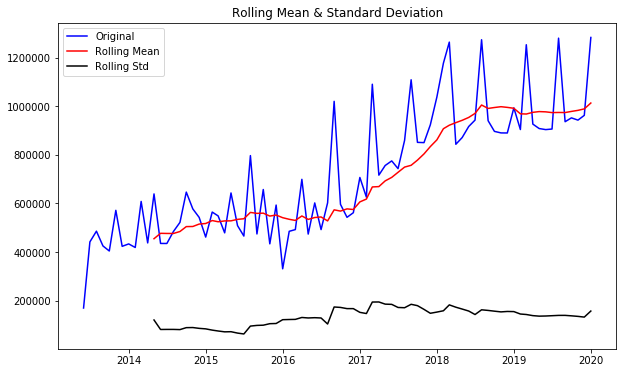

In [37]:
# plot rolling statistics and rolling std to determine if data is not stationary
orig = plt.plot(indexedDataset, color='blue', label= 'Original')
mean = plt.plot(rolemean, color='red', label='Rolling Mean')
std = plt.plot(rolstd, color='black', label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)


In [40]:
# Perform Dickey-Fuller test
# AIC Akaike information criterion, chooses the optimal laglength in a time series
# p value should be close to 0.5 & critical value should be more than the test statistic. if false, then data not stationary
from statsmodels.tsa.stattools import adfuller

print('Results of Dickey-Fuller Test')
dftest = adfuller(indexedDataset['Amount'], autolag='AIC')

dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value

print(dfoutput)

Results of Dickey-Fuller Test
Test Statistic                 -0.275033
p-value                         0.928967
#Lags Used                      5.000000
Number of Observations Used    74.000000
Critical Value (1%)            -3.521980
Critical Value (5%)            -2.901470
Critical Value (10%)           -2.588072
dtype: float64


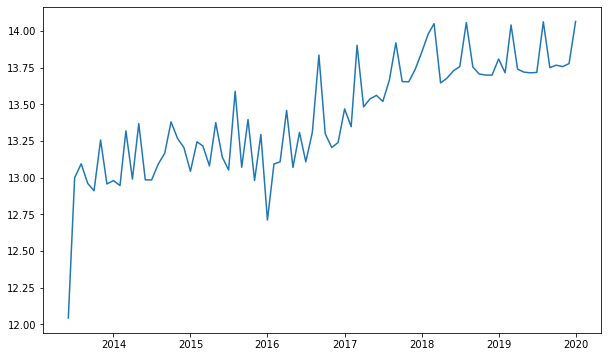

In [41]:
#Estimating the trend
indexedDataset_logScale = np.log(indexedDataset)
plt.plot(indexedDataset_logScale)

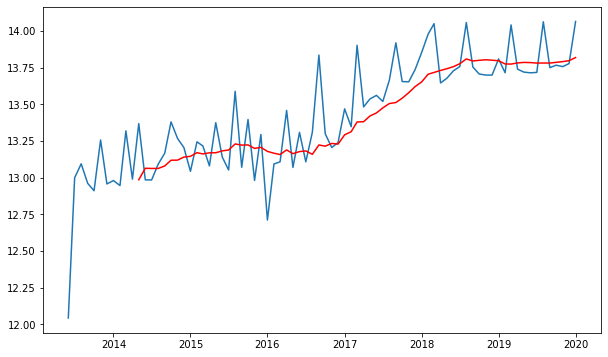

In [42]:
#log time series to show that is not stationary
movingAverage = indexedDataset_logScale.rolling(window=12).mean()
movingSTD = indexedDataset_logScale.rolling(window=12).std()
plt.plot(indexedDataset_logScale)
plt.plot(movingAverage, color='red')

In [44]:
# difference between the moving average and the actual expense amount
datasetLogScaleMinusMovingAverage = indexedDataset_logScale - movingAverage
datasetLogScaleMinusMovingAverage.head(12)

#remove Nan Values
datasetLogScaleMinusMovingAverage.dropna(inplace=True)
datasetLogScaleMinusMovingAverage.head(10)

,Amount
Month,
2014-05-01,0.383083
2014-06-01,-0.079191
2014-07-01,-0.078275
2014-08-01,0.029063
2014-09-01,0.086619
2014-10-01,0.261472
2014-11-01,0.147466
2014-12-01,0.064697
2015-01-01,-0.102291


In [54]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determining rolling statistics
    movingAverage = timeseries.rolling(window=12).mean()
    movingSTD = timeseries.rolling(window=12).std()
    
    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(movingAverage, color='red', label='Rolling Mean')
    std = plt.plot(movingSTD, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller Test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries['Amount\t'], autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

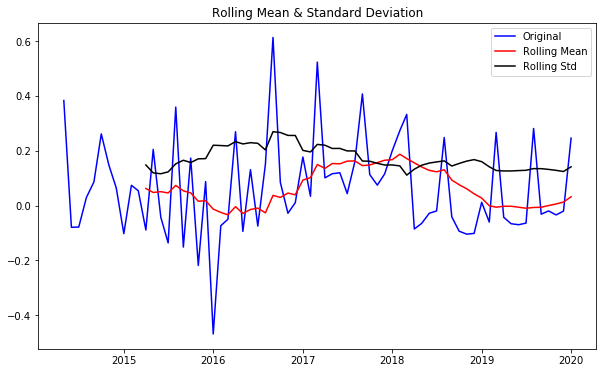

Results of Dickey-Fuller Test:
Test Statistic                 -2.231893
p-value                         0.194874
#Lags Used                      7.000000
Number of Observations Used    61.000000
Critical Value (1%)            -3.542413
Critical Value (5%)            -2.910236
Critical Value (10%)           -2.592745
dtype: float64


In [55]:
test_stationarity(datasetLogScaleMinusMovingAverage)

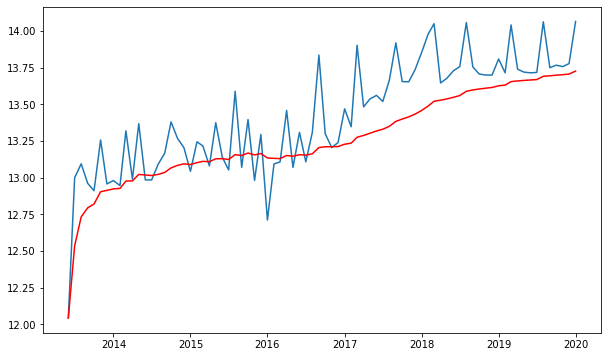

In [56]:
#To view the trend instide a time series
exponentialDecayWeightedAverage = indexedDataset_logScale.ewm(halflife=12, min_periods=0, adjust=True).mean()
plt.plot(indexedDataset_logScale)
plt.plot(exponentialDecayWeightedAverage, color='red')

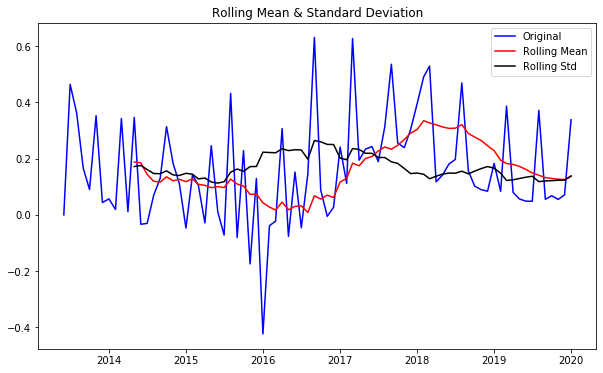

Results of Dickey-Fuller Test:
Test Statistic                 -1.780621
p-value                         0.390125
#Lags Used                      7.000000
Number of Observations Used    72.000000
Critical Value (1%)            -3.524624
Critical Value (5%)            -2.902607
Critical Value (10%)           -2.588679
dtype: float64


In [57]:
# another transformation.
datasetLogScaleMinusMovingExponentialDecayAverage = indexedDataset_logScale - exponentialDecayWeightedAverage
test_stationarity(datasetLogScaleMinusMovingExponentialDecayAverage)

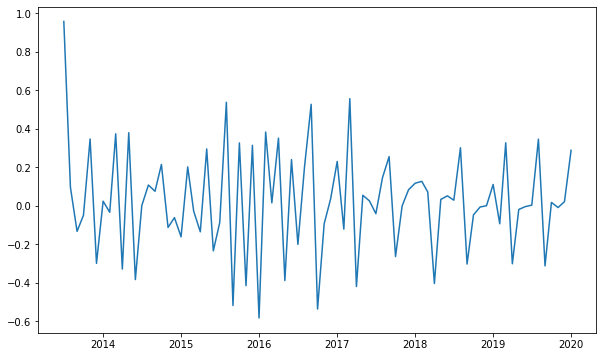

In [58]:
datasetLogDiffShifting = indexedDataset_logScale - indexedDataset_logScale.shift()
plt.plot(datasetLogDiffShifting)


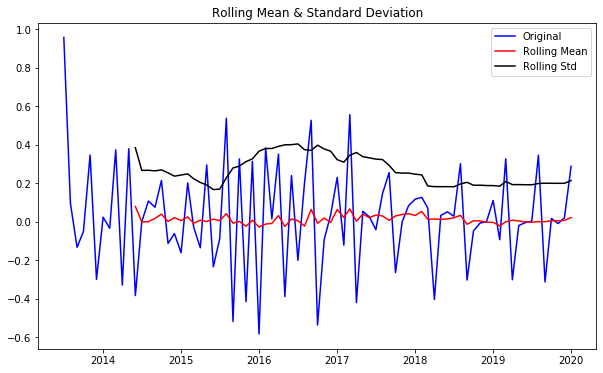

Results of Dickey-Fuller Test:
Test Statistic                -8.997561e+00
p-value                        6.631074e-15
#Lags Used                     4.000000e+00
Number of Observations Used    7.400000e+01
Critical Value (1%)           -3.521980e+00
Critical Value (5%)           -2.901470e+00
Critical Value (10%)          -2.588072e+00
dtype: float64


In [59]:
datasetLogDiffShifting.dropna(inplace=True)
test_stationarity(datasetLogDiffShifting)

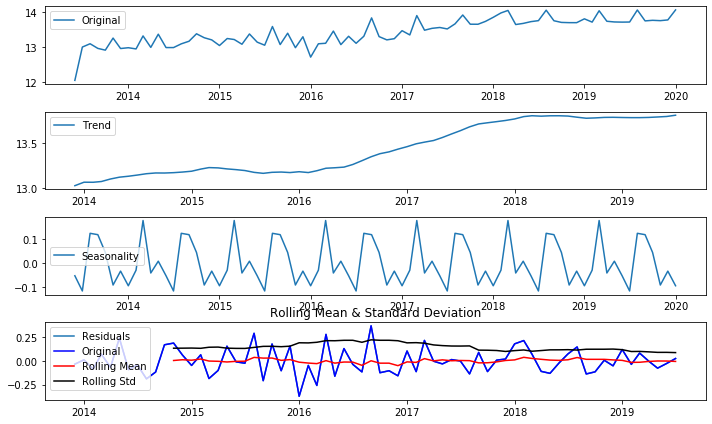

Results of Dickey-Fuller Test:


KeyError: 'Amount'

In [61]:
from statsmodels.tsa.seasonal import seasonal_decompose 
decomposition = seasonal_decompose(indexedDataset_logScale)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(indexedDataset_logScale, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal, label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

decomposedLogData = residual
decomposedLogData.dropna(inplace=True)
test_stationarity(decomposedLogData)